In [1]:
import numpy as np
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
import os
from dotenv import load_dotenv
from torch import nn
import torch
import pickle
import torch.optim as optim
from torch.autograd import grad
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader

load_dotenv()

def get_spike_intervals(spike_times, start_times, stop_times):
    spikes_in_intervals = {}

    # Convert start_times and stop_times to numpy arrays for faster operations
    start_times = np.array(start_times)
    stop_times = np.array(stop_times)

    print(start_times-stop_times)

    # Loop through each neuron, but optimize the spike finding with vectorized operations
    for neuron_id, times in spike_times.items():
        # Convert times to a numpy array if it's not already
        times = np.array(times)
        
        # Use numpy's searchsorted to find the indices where the start and stop times would fit
        start_indices = np.searchsorted(times, start_times, side='left')
        stop_indices = np.searchsorted(times, stop_times, side='right')
        
        # Get the number of spikes in each interval by subtracting indices
        spikes_in_intervals[neuron_id] = stop_indices - start_indices
    
    return spikes_in_intervals


# Sample LNP Model definition
class LNPModel(nn.Module):
    def __init__(self, input_dim, n_neurons):
        super(LNPModel, self).__init__()
        self.linear = nn.Linear(input_dim, 10)  # Linear layer for each neuron
        self.linear2=nn.Linear(10, n_neurons)
    
    def forward(self, x):
        x = self.linear(x)
        x=self.linear2(x)
        firing_rate = torch.exp(x)  # Exponential non-linearity
        return firing_rate

class FrontierPipeline:
    def __init__(self, session_id=831882777):
        output_dir=os.environ['ALLEN_NEUROPIXELS_PATH']
        manifest_path = os.path.join(output_dir, "manifest.json")
        self.cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
        self.session= self.cache.get_session_data(session_id)
        self.stimuli_df=self.session.stimulus_presentations
        embeddings=pickle.load(open('/home/maria/Documents/HuggingMouseData/TransformerEmbeddings/openai_clip-vit-base-patch32_embeddings.pkl','rb'))['natural_movie_one']
        self.embeddings=torch.tensor(embeddings, dtype=torch.float32)

    def training_loop(self, lnp_model, real_spikes_tensor, trial_index):
        # Training loop
        # Loss function (Negative Log-Likelihood) and Optimizer
        criterion = nn.PoissonNLLLoss(log_input=False)  # Poisson Negative Log-Likelihood Loss
        optimizer = optim.Adam(lnp_model.parameters(), lr=0.001, weight_decay=1e-2)
        num_epochs = 10000
        delta=0.0333
        for epoch in range(num_epochs):
            lnp_model.train()
            
            # Forward pass
            predicted_firing_rate = lnp_model(self.embeddings).squeeze()*delta
            
            # Compute loss
            loss = criterion(predicted_firing_rate, real_spikes_tensor)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Print loss
            if (epoch+1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        print('Training finished')
        weights=lnp_model.linear2.weight.detach().numpy()
        return lnp_model, weights
    
    def __call__(self, trial_index, stimulus_type='natural_movie_one_more_repeats'):
        stim = self.stimuli_df[self.stimuli_df['stimulus_name'] == stimulus_type]
        spike_times=self.session.spike_times
        spike_times=get_spike_intervals(spike_times,stim['start_time'].values,stim['stop_time'].values)
        spikes=torch.tensor([spike_times[key] for key in spike_times.keys()],dtype=torch.float32)[:,trial_index*900:(trial_index+1)*900].T
        lnp=LNPModel(self.embeddings.shape[1], len(spike_times.keys()))
        lnp_model, weights=self.training_loop(lnp,spikes,trial_index)

        return lnp_model, weights, self.embeddings

/home/maria/NeuroGarage/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pipeline=FrontierPipeline()
for i in range(1):
    lnp_model, weights, embeddings=pipeline(i)

/home/maria/NeuroGarage/.venv/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/home/maria/NeuroGarage/.venv/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


[-0.03336096 -0.03336096 -0.03336096 ... -0.0333607  -0.0333607
 -0.0333607 ]
Epoch [10/10000], Loss: 0.7523
Epoch [20/10000], Loss: 0.7319
Epoch [30/10000], Loss: 0.7053
Epoch [40/10000], Loss: 0.6709
Epoch [50/10000], Loss: 0.6295
Epoch [60/10000], Loss: 0.5849
Epoch [70/10000], Loss: 0.5416
Epoch [80/10000], Loss: 0.5023
Epoch [90/10000], Loss: 0.4689
Epoch [100/10000], Loss: 0.4412
Epoch [110/10000], Loss: 0.4193
Epoch [120/10000], Loss: 0.4035
Epoch [130/10000], Loss: 0.3925
Epoch [140/10000], Loss: 0.3850
Epoch [150/10000], Loss: 0.3804
Epoch [160/10000], Loss: 0.3778
Epoch [170/10000], Loss: 0.3760
Epoch [180/10000], Loss: 0.3746
Epoch [190/10000], Loss: 0.3736
Epoch [200/10000], Loss: 0.3729
Epoch [210/10000], Loss: 0.3723
Epoch [220/10000], Loss: 0.3719
Epoch [230/10000], Loss: 0.3715
Epoch [240/10000], Loss: 0.3712
Epoch [250/10000], Loss: 0.3710
Epoch [260/10000], Loss: 0.3709
Epoch [270/10000], Loss: 0.3707
Epoch [280/10000], Loss: 0.3706
Epoch [290/10000], Loss: 0.3704
Epo

In [16]:
def calculate_Fisher_matrix(lnp_model, weights, embeddings):
    firing_rate=lnp_model(embeddings)
    print(firing_rate.shape)
    delta=0.0333
    take_neuron_0=firing_rate[:,0].detach().numpy()*delta
    print(take_neuron_0.shape)
    #Shape 768x900
    emb_matrix=embeddings.detach().numpy().T@embeddings.detach().numpy()
    #Shape 768x768-- embedding shape
    # Reshape take_neuron_0 to broadcast along the embedding matrix dimensions
    take_neuron_0 = take_neuron_0.reshape(-1, 1, 1)  # Shape (900, 1, 1)
    
    # Broadcast to create the scaled embedding matrix for each observation
    fisher_matrix = take_neuron_0 * emb_matrix  # Shape (900, 768, 768)
    
    # Sum across the 0 axis to get the Fisher information matrix
    fisher_matrix = fisher_matrix.mean(axis=0)  # Shape (768, 768)
    print(fisher_matrix.shape)  # Expected shape (768, 768)
    
    return fisher_matrix

fisher_mat=calculate_Fisher_matrix(lnp_model, weights, embeddings)

torch.Size([900, 657])
(900,)
(768, 768)


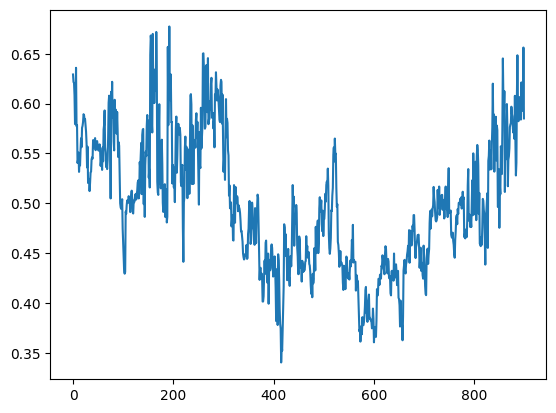

In [21]:
firing_rate=lnp_model(embeddings)

plt.plot(firing_rate[:,3].detach().numpy()*0.0333)

array([[ 195.06564 ,  -36.704666,  -77.141174, ..., -167.54512 ,
         -92.67955 ,    9.914921],
       [ -36.704666, 3292.4392  , 1859.9827  , ...,  969.1787  ,
        1790.7876  , 1595.3572  ],
       [ -77.141174, 1859.9827  , 1272.0707  , ...,  731.3433  ,
        1083.2087  ,  958.20013 ],
       ...,
       [-167.54512 ,  969.1787  ,  731.3433  , ...,  876.07544 ,
         688.3127  ,  589.01807 ],
       [ -92.67955 , 1790.7876  , 1083.2087  , ...,  688.3127  ,
        1128.4988  ,  900.6164  ],
       [   9.914921, 1595.3572  ,  958.20013 , ...,  589.01807 ,
         900.6164  ,  941.35785 ]], dtype=float32)

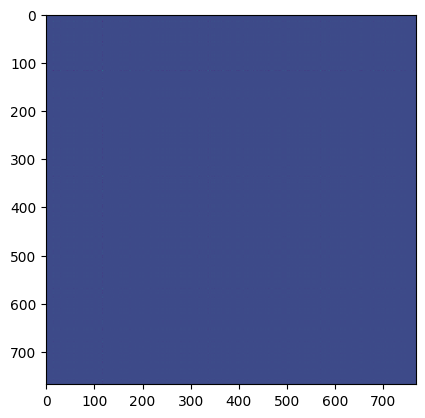

In [18]:
import matplotlib.pyplot as plt

plt.imshow(fisher_mat)
fisher_mat